In [1]:
import cv2
import numpy as np
import os
from time import time
import supervision as sv
import matplotlib.pyplot as plt

import torch
from collections import Counter
from tqdm import tqdm


In [2]:

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct Labels of Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    # Slicing idx:idx+1 in order to keep tensor dimensionality
    # Doing ... in indexing if there would be additional dimensions
    # Like for Yolo algorithm which would have (N, S, S, 4) in shape
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Need clamp(0) in case they do not intersect, then we want intersection to be 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [3]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=1
):
    """
    Calculates mean average precision 

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [4]:
def nms(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [30]:
class TumorCascade(object):
    def __init__(self, device, box_format="midpoint", num_classes=1):
        self.model = cv2.CascadeClassifier('models/cascade.xml')
        self.device = device
        self.box_format = box_format
        self.num_classes = num_classes

    def predict(self, img, normalized = False, nms_threshold = 0.5, score_threshold = 0.5):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        boxes = self.model.detectMultiScale(gray, 1.1, 4)

        boxes = [[0, 1 , x, y, w, h] for x, y, w, h in boxes]
        boxes = nms(boxes, nms_threshold, score_threshold, self.box_format)
        if normalized:
            w, h = img.shape[1], img.shape[0]
            return w, h,  boxes
        return boxes
    
    def preprocess(self, img):
        return img
    
    def get_boxes(self, label_dir , format = 'yolo', index = 0 ,w_img = None , h_img = None):
        if format == 'yolo':
            with open(label_dir, 'r') as f:
                boxes = f.readlines()
                boxes = [box.strip().split() for box in boxes]
                formatted_boxes = []
                for class_pred, x, y, w, h in boxes:
                    x, y, w, h = float(x), float(y), float(w), float(h)

                    if self.box_format == "midpoint":
                        x = (x - w / 2) 
                        y = (y - h / 2) 
                    if w_img is not None and w_img>= 0 and h_img is not None and  h_img >= 0:
                        x = int(x*w_img)
                        y = int(y*h_img)
                        w = int(w*w_img)
                        h = int(h*h_img)
                    formatted_boxes.append([index, int(class_pred), 1, x, y, w, h])
            return formatted_boxes
                
        else:
            return None

    
    def evaluate(self, images_dir, labels_dir):
        pred_boxes = []
        true_boxes = []
        for index , img_name in tqdm(enumerate(os.listdir(images_dir))):
            image_path = os.path.join(images_dir, img_name)
            # print(image_path)
            img = cv2.imread(image_path)
            
            w, h, boxes = self.predict(img, normalized=True)
            pred_boxes += [[index, class_pred, score, x, y, w, h] for class_pred, score, x, y, w, h in boxes]
            true_boxes += self.get_boxes(os.path.join(labels_dir, img_name.replace('jpg', 'txt')), index = index, w_img = w, h_img = h)

            # print('pred_boxes:', pred_boxes)    
            # print('true_boxes:', true_boxes)
        results = []
        iou_thresholds = np.arange(0.1, 1, 0.1)
        for iou_threshold in iou_thresholds:
            result = mean_average_precision(pred_boxes, true_boxes, iou_threshold, self.box_format, self.num_classes).item()
            results.append(result)
            print(f"mAP @ {np.round(iou_threshold,2)}: {np.round(result,2)}" )
        return iou_thresholds, results
        

In [31]:
model = TumorCascade('cpu')

Testing...
The Blue bounding boxes are predicted by the model
The Red bounding boxes are the ground truth


0it [00:00, ?it/s]

100it [00:02, 40.97it/s]


mAP @ 0.1: 0.38
mAP @ 0.2: 0.37
mAP @ 0.3: 0.33
mAP @ 0.4: 0.28
mAP @ 0.5: 0.24
mAP @ 0.6: 0.21
mAP @ 0.7: 0.12
mAP @ 0.8: 0.02
mAP @ 0.9: 0.0


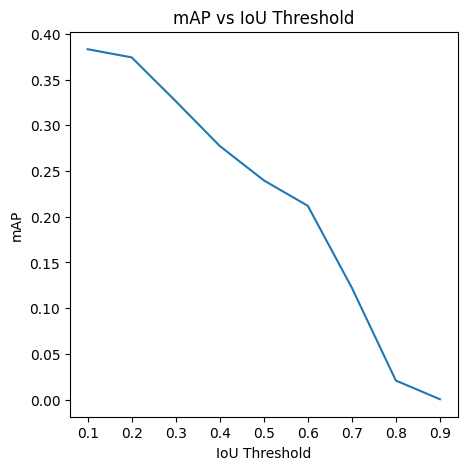

Testing completed


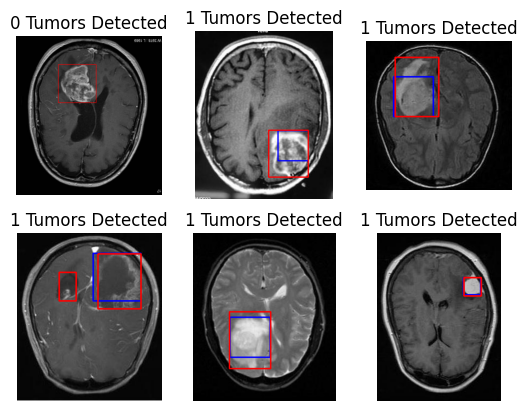

In [33]:
num_test = 6
#Test haar cascade classifier
TEST_IMG_DIR = "dataset/test/images"
TEST_LABELS_DIR = "dataset/test/labels"

def test_model(model = model, num_test = num_test , test_img_dir = TEST_IMG_DIR, test_labels_dir = TEST_LABELS_DIR):
    #Create matplotlib subplot equals to num_test
    print("Testing...")
    print("The Blue bounding boxes are predicted by the model")
    print("The Red bounding boxes are the ground truth")

    thresholds, mAP = model.evaluate(test_img_dir, test_labels_dir)

    plt.figure(figsize=(5, 5))
    plt.plot(thresholds, mAP)
    plt.title("mAP vs IoU Threshold")
    plt.xlabel("IoU Threshold")
    plt.ylabel("mAP")
    plt.show()


    if num_test % 3 ==0: 
        fig, axs = plt.subplots(num_test//3, 3 )
    else:
        fig, axs = plt.subplots(num_test//3 +1, 3 )

    axs = axs.ravel()

    all_images = os.listdir(TEST_IMG_DIR)

    for i in range(num_test):
        img_name = np.random.choice(all_images)
        img_path = os.path.join(TEST_IMG_DIR, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)        
        tumors = model.predict(img)
        w, h = img.shape[1], img.shape[0]
        label_name = img_name.replace('jpg', 'txt')
        labels = model.get_boxes(f"{TEST_LABELS_DIR}/{label_name}".format(id=id), w_img=w, h_img=h)
        for (class_pred, prob_score, x,y,w,h) in tumors:
            cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)

        
        for (index, class_pred, prob_score, x, y, w, h) in labels:
            cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 2)
        
        title = f"{len(tumors)} Tumors Detected"
        axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i].axis('off')
        axs[i].set_title(title)
    print("Testing completed")
    plt.show()
    
        

test_model()
 